### Dataset source :
##### https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

#### Notebook tested with : Python 2.7 and 3.5, Conda environment

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function # for Python 2.7 compatibility

In [3]:
from IPython.display import display, HTML

In [4]:
def display_pd(some_df):
    display(HTML(some_df.to_html()))

In [5]:
import operator
import math
import pandas as pd
import numpy as np
import scipy.stats as ss

In [6]:
from sklearn.metrics import accuracy_score
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb # INFO : conda install -c aterrel xgboost=0.4.0.c4fa2f

In [7]:
import seaborn as sns # for charts only, see : http://seaborn.pydata.org/examples/paired_pointplots.html

In [8]:
# see thread : https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = float(ss.chi2_contingency(confusion_matrix)[0])
    n = float(confusion_matrix.sum())
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


def cramers_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

## Load datasets

In [9]:
dfX = pd.read_csv('PUMP_training_set_values.csv')
dfY = pd.read_csv('PUMP_training_set_labels.csv')

In [10]:
assert(dfX.shape[0] == dfY.shape[0])

dfX.shape[0], dfX.shape[1], dfY.shape[1] # The size of the dataset : some models/algos require large datasets

(59400, 40, 2)

In [11]:
display_pd(dfX.head(5)) # special display to see all columns

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [12]:
dfY.head(5) # this shows us the target variable i.e. what we will predict

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


## Handling of Null data

In [13]:
# Find columns with Null values
nullcols = []
for col in dfX.columns:
    nbnull = (dfX[col].isnull()*1).sum()
    if ( nbnull > 0 ):
        t = type(dfX[dfX[col].notnull()][col].iat[0]) # type of first non null value
        nullcols.append([col, t])
        print(col, nbnull, t)

funder 3635 <type 'str'>
installer 3655 <type 'str'>
subvillage 371 <type 'str'>
public_meeting 3334 <type 'bool'>
scheme_management 3877 <type 'str'>
scheme_name 28166 <type 'str'>
permit 3056 <type 'bool'>


In [14]:
# Fill Null values in string columns with "MISSING"
for col, t in nullcols:
    if (t == type('abc')):
        dfX.loc[dfX[col].isnull(), col] = 'MISSING'
        
# For boolean (just a special case of categorie) : convert into string, then replace Null with "MISSING"
for col, t in nullcols:
    if (t == type(True)):
        dfX.loc[dfX[col]==True, col] = 'TRUE'
        dfX.loc[dfX[col]==False, col] = 'FALSE'
        dfX.loc[dfX[col].isnull(), col] = 'MISSING'

In [15]:
dfX.columns # list all columns

Index([u'id', u'amount_tsh', u'date_recorded', u'funder', u'gps_height',
       u'installer', u'longitude', u'latitude', u'wpt_name', u'num_private',
       u'basin', u'subvillage', u'region', u'region_code', u'district_code',
       u'lga', u'ward', u'population', u'public_meeting', u'recorded_by',
       u'scheme_management', u'scheme_name', u'permit', u'construction_year',
       u'extraction_type', u'extraction_type_group', u'extraction_type_class',
       u'management', u'management_group', u'payment', u'payment_type',
       u'water_quality', u'quality_group', u'quantity', u'quantity_group',
       u'source', u'source_type', u'source_class', u'waterpoint_type',
       u'waterpoint_type_group'],
      dtype='object')

In [16]:
display_pd(dfX.describe())

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


## Target variable

In [17]:
# Numerical encoding of the target variable as it is categorical

catenc = pd.factorize(dfY['status_group'])
dfY['status_group_enc'] = catenc[0]
dfY['status_group_enc'] = dfY['status_group_enc'] - dfY['status_group_enc'].min() # offset to base 0

dfY['label'] = (dfY['status_group'] == 'functional')*1

In [18]:
dfY[['id','status_group','status_group_enc','label']].head(10)

,id,status_group,status_group_enc,label
0,69572,functional,0,1
1,8776,functional,0,1
2,34310,functional,0,1
3,67743,non functional,1,0
4,19728,functional,0,1
5,9944,functional,0,1
6,19816,non functional,1,0
7,54551,non functional,1,0
8,53934,non functional,1,0
9,46144,functional,0,1


## Numerical variables

In [19]:
numerics = ['amount_tsh', 'population']
dfX[numerics].head(8)

,amount_tsh,population
0,6000.0,109
1,0.0,280
2,25.0,250
3,0.0,58
4,0.0,0
5,20.0,1
6,0.0,0
7,0.0,0


In [20]:
dfX[numerics].describe()

,amount_tsh,population
count,59400.000000,59400.000000
mean,317.650385,179.909983
std,2997.574558,471.482176
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,25.000000
75%,20.000000,215.000000
max,350000.000000,30500.000000


In [21]:
for col in numerics: # Check frequency of most common values
    cs = dfX[col].value_counts(normalize=True, sort=True, ascending=False)
    for k in cs.keys()[0:5]:
        print( col, k, int(cs[k]*10000)/100. )
    print('')

amount_tsh 0.0 70.09
amount_tsh 500.0 5.22
amount_tsh 50.0 4.16
amount_tsh 1000.0 2.5
amount_tsh 20.0 2.46

population 0 35.99
population 1 11.82
population 200 3.26
population 150 3.18
population 250 2.82



In [22]:
# WARNING : too many 0's (and 1's for population) so we create is_zero dummy variables
dfX['amount_tsh_zero'] = (dfX['amount_tsh']==0)*1
numerics.append( 'amount_tsh_zero' )

dfX['population_zero'] = (dfX['population']==0)*1
numerics.append( 'population_zero' )

dfX['population_one'] = (dfX['population']==1)*1
numerics.append( 'population_one' )

## Date/Time variables

In [23]:
dates = ['date_recorded', 'construction_year']
dfX[dates].head(8)

,date_recorded,construction_year
0,2011-03-14,1999
1,2013-03-06,2010
2,2013-02-25,2009
3,2013-01-28,1986
4,2011-07-13,0
5,2011-03-13,2009
6,2012-10-01,0
7,2012-10-09,0


In [24]:
for col in dates: # Check frequency of most common values
    cs = dfX[col].value_counts(normalize=True, sort=True, ascending=False)
    for k in cs.keys()[0:5]:
        print( col, k, int(cs[k]*10000)/100. )
    print('')

# WARNING : "construction_year" is 0 for one-third of the records

date_recorded 2011-03-15 0.96
date_recorded 2011-03-17 0.93
date_recorded 2013-02-03 0.91
date_recorded 2011-03-14 0.87
date_recorded 2011-03-16 0.86

construction_year 0 34.86
construction_year 2010 4.45
construction_year 2008 4.39
construction_year 2009 4.26
construction_year 2000 3.52



In [25]:
# Split date_recorded stamp (string) into year, month, day of month, day of week features
from dateutil import parser

dfX['date_recorded_year'] = dfX['date_recorded'].apply(lambda x: int(x.split('-')[0]))
dates.append('date_recorded_year')

dfX['date_recorded_month'] = dfX['date_recorded'].apply(lambda x: int(x.split('-')[1]))
dates.append('date_recorded_month')

# WARNING : probably not usefull for this dataset
#dfX['date_recorded_day'] = dfX['date_recorded'].apply(lambda x: int(x.split('-')[2]))
#dates.append('date_recorded_day')

dfX['date_recorded_weekday'] = dfX['date_recorded'].apply(lambda x: str(parser.parse(x).weekday())) # category
dates.append('date_recorded_weekday')

dfX['date_recorded_isweekend'] = dfX['date_recorded'].apply(lambda x: int(parser.parse(x).weekday() in [5,6])) # binary
dates.append('date_recorded_isweekend')

In [26]:
dfX[dates].describe() # WARNING : construction_year has a lot of "0" missing values

,construction_year,date_recorded_year,date_recorded_month,date_recorded_isweekend
count,59400.000000,59400.000000,59400.000000,59400.000000
mean,1300.652475,2011.921667,4.375640,0.264141
std,951.620547,0.958758,3.029247,0.440879
min,0.000000,2002.000000,1.000000,0.000000
25%,0.000000,2011.000000,2.000000,0.000000
50%,1986.000000,2012.000000,3.000000,0.000000
75%,2004.000000,2013.000000,7.000000,1.000000
max,2013.000000,2013.000000,12.000000,1.000000


In [27]:
dfX['construction_year_missing'] = (dfX['construction_year']==0)*1 # before filling the null keep track of them
dates.append( 'construction_year_missing' )

mean_year = dfX[dfX['construction_year']>0]['construction_year'].mean() # WARNING : oldest ? median ? mean ?
print(mean_year)

dfX.loc[dfX['construction_year']==0, 'construction_year'] = mean_year

1996.81468559


In [28]:
nbQs = 4 # WARNING : error messages with higher values
dfX['construction_year_quantile'] = pd.qcut(dfX['construction_year'], nbQs, labels=False)/(nbQs-1.0)
dates.append( 'construction_year_quantile' )

## Geographical variables

In [29]:
geos = ['gps_height','longitude','latitude','basin','subvillage','region','region_code','district_code','lga','ward']
dfX[geos].head(8)

# WARNING : in many cases we dont have HEIGHT but we could get it from (Lat,Long) coordinates

,gps_height,longitude,latitude,basin,subvillage,region,region_code,district_code,lga,ward
0,1390,34.938093,-9.856322,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi
1,1399,34.698766,-2.147466,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta
2,686,37.460664,-3.821329,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika
3,263,38.486161,-11.155298,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu
4,0,31.130847,-1.825359,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi
5,0,39.172796,-4.765587,Pangani,Moa/Mwereme,Tanga,4,8,Mkinga,Moa
6,0,33.362410,-3.766365,Internal,Ishinabulandi,Shinyanga,17,3,Shinyanga Rural,Samuye
7,0,32.620617,-4.226198,Lake Tanganyika,Nyawishi Center,Shinyanga,17,3,Kahama,Chambo


In [30]:
for col in geos: # Check frequency of most common values
    cs = dfX[col].value_counts(normalize=True, sort=True, ascending=False)
    for k in cs.keys()[0:5]:
        print( col, k, int(cs[k]*10000)/100. )
    print('')

gps_height 0 34.4
gps_height -15 0.1
gps_height -16 0.09
gps_height -13 0.09
gps_height -20 0.08

longitude 0.0 3.05
longitude 37.23632569 0.0
longitude 32.9780624 0.0
longitude 32.92488627 0.0
longitude 38.34050134 0.0

latitude -2e-08 3.05
latitude -6.96356538 0.0
latitude -2.49645868 0.0
latitude -2.46524583 0.0
latitude -7.10374232 0.0

basin Lake Victoria 17.25
basin Pangani 15.05
basin Rufiji 13.42
basin Internal 13.1
basin Lake Tanganyika 10.82

subvillage Madukani 0.85
subvillage Shuleni 0.85
subvillage Majengo 0.84
subvillage Kati 0.62
subvillage MISSING 0.62

region Iringa 8.91
region Shinyanga 8.38
region Mbeya 7.8
region Kilimanjaro 7.37
region Morogoro 6.74

region_code 11 8.92
region_code 17 8.43
region_code 12 7.8
region_code 3 7.37
region_code 5 6.8

district_code 1 20.54
district_code 2 18.8
district_code 3 16.83
district_code 4 15.14
district_code 5 7.33

lga Njombe 4.21
lga Arusha Rural 2.1
lga Moshi Rural 2.1
lga Bariadi 1.98
lga Rungwe 1.86

ward Igosi 0.51
ward Im

In [31]:
# WARNING :
# - Too many 0's for gps (lat,long,height) : fill with mean of "basin"/"region"/"lga"/"ward"
# - according to wikipedia the lowest point is at 0m : need to take absolute level ?

bound_df = dfX[(dfX['latitude']<-0.5)&(dfX['longitude']>25)&(dfX['gps_height']>0)]
print( bound_df.groupby(['basin',])['id'].count().min() ) # check enough data in each bucket

mean_geo_df = bound_df.groupby(['basin',])['latitude','longitude','gps_height'].mean()

assert(mean_geo_df.shape[0] == len(dfX['basin'].unique()))

mean_geo_df

1012


,latitude,longitude,gps_height
basin,,,
Internal,-4.137060,35.471586,1474.550470
Lake Nyasa,-10.021460,34.772641,1524.654237
Lake Rukwa,-7.489675,31.500196,1415.137352
Lake Tanganyika,-4.938659,30.398291,1270.063242
Lake Victoria,-1.868478,34.004127,1329.265008
Pangani,-3.849383,37.546848,1102.257742
Rufiji,-8.483380,35.852000,1087.780631
Ruvuma / Southern Coast,-10.547087,38.156886,455.058376
Wami / Ruvu,-6.712766,38.170352,308.914208


In [32]:
# WARNING :
# - replace strange value with local mean
# - an alternative would be to replace with local random sample to avoid over-weighting of any value

# Before over-writing keep track of suspect rows with new binary columns
dfX['gps_height_bad'] = (dfX['gps_height']<=0)*1
geos.append('gps_height_bad')
dfX['longitude_bad'] = (dfX['longitude']<25)*1
geos.append('longitude_bad')
dfX['latitude_bad'] = (dfX['latitude']>-0.5)*1
geos.append('latitude_bad')

# Exemple of query via index=basin : mean_geo_df.at['Lake Victoria','latitude']
dfX.loc[dfX['gps_height']<=0, 'gps_height'] = dfX['basin'].apply(lambda x : mean_geo_df.at[x,'gps_height'])
dfX.loc[dfX['longitude']<25, 'longitude'] = dfX['basin'].apply(lambda x : mean_geo_df.at[x,'longitude'])
dfX.loc[dfX['latitude']>-0.5, 'latitude'] = dfX['basin'].apply(lambda x : mean_geo_df.at[x,'latitude'])

In [33]:
dfX[geos].describe() # WARNING : region_code, district_code are categories

,gps_height,longitude,latitude,region_code,district_code,gps_height_bad,longitude_bad,latitude_bad
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,1126.611330,35.108715,-5.768148,15.297003,5.629747,0.369259,0.030505,0.030505
std,516.692645,2.581681,2.847390,17.587406,9.633649,0.482608,0.171974,0.171974
min,1.000000,29.607122,-11.649440,1.000000,0.000000,0.000000,0.000000,0.000000
25%,828.000000,33.341782,-8.540621,5.000000,2.000000,0.000000,0.000000,0.000000
50%,1315.000000,34.908743,-5.021597,12.000000,3.000000,0.000000,0.000000,0.000000
75%,1474.550470,37.178387,-3.328977,17.000000,5.000000,1.000000,0.000000,0.000000
max,2770.000000,40.345193,-0.998464,99.000000,80.000000,1.000000,1.000000,1.000000


In [34]:
for col in ['basin','subvillage','region','region_code','district_code','lga','ward']:
    totalfreq_top100 = dfX[col].value_counts(normalize=True, sort=True, ascending=False)[0:100].sum()
    print( col, len(dfX[col].unique()), round(totalfreq_top100*100) )
    
# WARNING :
# probably a hierarchy here with **basin** at coarser level and **subvillage** at finer level
# Documentation is vague but can check on Wikipedia some of the specific locations

basin 9 100.0
subvillage 19288 15.0
region 21 100.0
region_code 27 100.0
district_code 20 100.0
lga 125 95.0
ward 2092 20.0


In [35]:
# Remove fields with only low frequency values
dfX = dfX.drop('subvillage', axis=1)
geos.remove('subvillage')

dfX = dfX.drop('ward', axis=1)
geos.remove('ward')

In [36]:
# WARNING
# WARNING
# WARNING
# We should also add a 4x4 grid over the map and have kernel weights to their centers
# This way we can estimate a special contribution to some points with a smooth transition intead of "regions"

## Remaining categorical variables

In [36]:
categories = [col for col in list(dfX.columns) if not(col in geos) and not(col in dates) and not (col in numerics)]
categories.remove('id')

In [37]:
for col in categories:
    print(col, len(dfX[col].unique()))

funder 1898
installer 2146
wpt_name 37400
num_private 65
public_meeting 3
recorded_by 1
scheme_management 13
scheme_name 2697
permit 3
extraction_type 18
extraction_type_group 13
extraction_type_class 7
management 12
management_group 5
payment 7
payment_type 7
water_quality 8
quality_group 6
quantity 5
quantity_group 5
source 10
source_type 7
source_class 3
waterpoint_type 7
waterpoint_type_group 6


In [38]:
# WARNING : we note that "recorded_by" only has 1 value so we discard this column
dfX = dfX.drop('recorded_by', axis=1)
categories.remove('recorded_by')

In [39]:
for col in categories:
    cs = dfX[col].value_counts(normalize=False, sort=True, ascending=False)
    print( col, len([cs[k] for k in cs.keys() if cs[k]>=40]), len(dfX[col].unique()) )

funder 168 1898
installer 164 2146
wpt_name 56 37400
num_private 6 65
public_meeting 3 3
scheme_management 12 13
scheme_name 132 2697
permit 3 3
extraction_type 16 18
extraction_type_group 13 13
extraction_type_class 7 7
management 12 12
management_group 5 5
payment 7 7
payment_type 7 7
water_quality 7 8
quality_group 6 6
quantity 5 5
quantity_group 5 5
source 10 10
source_type 7 7
source_class 3 3
waterpoint_type 6 7
waterpoint_type_group 5 6


In [40]:
# WARNING :
# Before one-hot-encoding we ***can*** try to replace all rare categories with a single "rare" value
if True:
    for col in categories:
        cs = dfX[col].value_counts(normalize=False, sort=True, ascending=False)
        rare_values = [k for k in cs.keys() if cs[k]<40]
        if len(rare_values)>0:
            print( 'Trim values : ', col, len(rare_values))
            dfX.loc[dfX[col].isin(rare_values), col] = col+'_rare'

Trim values :  funder 1730
Trim values :  installer 1982
Trim values :  wpt_name 37344
Trim values :  num_private 59
Trim values :  scheme_management 1
Trim values :  scheme_name 2565
Trim values :  extraction_type 2
Trim values :  water_quality 1
Trim values :  waterpoint_type 1
Trim values :  waterpoint_type_group 1


## Interaction between X variables

In [41]:
# Search for variables that are very similar and remove "near duplicates"

def show_similars(cols, threshold=0.90):
    for i1, col1 in enumerate(cols):
        for i2, col2 in enumerate(cols):
            if (i1<i2):
                cm12 = pd.crosstab(dfX[col1], dfX[col2]).values # confusion matrix
                cv12 = cramers_corrected_stat(cm12) # WARNING : cramer V is a symetric stat ?
                if (cv12 > threshold):
                    print((col1, col2), int(cv12*100))

show_similars(['basin','region','region_code','district_code','lga'], 0.95)
print('')
show_similars(categories, 0.95)

('region', 'region_code') 99
('region', 'lga') 99
('region_code', 'lga') 97

('extraction_type', 'extraction_type_group') 99
('extraction_type', 'extraction_type_class') 99
('extraction_type_group', 'extraction_type_class') 99
('management', 'management_group') 99
('payment', 'payment_type') 100
('water_quality', 'quality_group') 99
('quantity', 'quantity_group') 100
('source', 'source_type') 99
('source', 'source_class') 99
('source_type', 'source_class') 99
('waterpoint_type', 'waterpoint_type_group') 99


In [42]:
# We see that the following are very similar :
#  ('region', 'region_code', 'lga')
#  ('extraction_type', 'extraction_type_group', 'extraction_type_class')
#  ('management', 'management_group')
#  ('payment', 'payment_type')
#  ('water_quality', 'quality_group')
#  ('quantity', 'quantity_group')
#  ('source', 'source_type', 'source_class')
#  ('waterpoint_type', 'waterpoint_type_group')

for col in ['region_code', 'lga']:
    dfX = dfX.drop(col, axis=1)
    geos.remove(col)
    
for col in ['extraction_type_group', 'extraction_type_class',
            'management_group',
            'payment_type',
            'quality_group',
            'quantity_group',
            'source_type', 'source_class',
            'waterpoint_type_group']:
    dfX = dfX.drop(col, axis=1)
    categories.remove(col)

## Merge X and Y datasets

In [43]:
df = dfX.merge(dfY, left_on='id', right_on='id', how='inner')

# To check merge is as expected
L1 = df[dfX.columns.values].set_index('id', inplace=False).sort_index(axis=0)
R1 = dfX.set_index('id', inplace=False).sort_index(axis=0)
assert( L1.equals(R1) )

L2 = df[dfY.columns.values].set_index('id', inplace=False).sort_index(axis=0)
R2 = dfY.set_index('id', inplace=False).sort_index(axis=0)
assert( L2.equals(R2) )

df = df.sample(frac=1) # WARNING : Shuffle in case initial order was not random

## Explanatory power of X variables on Y variable

#### Charts : not convenient with so many categorical variables

In [44]:
#sns.countplot(df['status_group'])

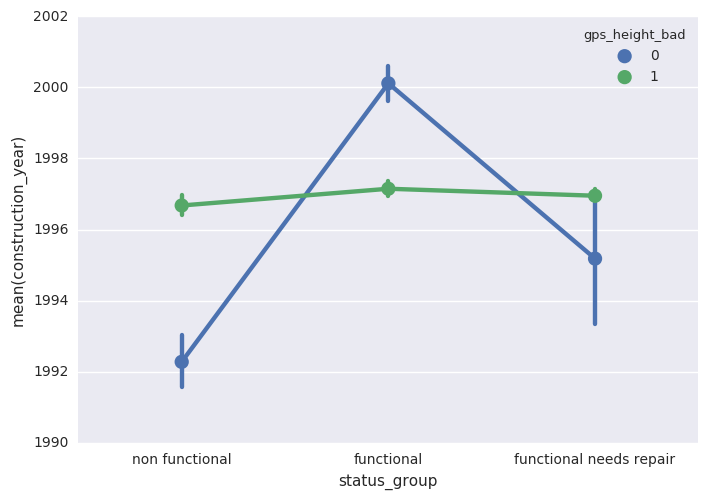

In [45]:
sns.pointplot(x="status_group", y="construction_year", hue="gps_height_bad", data=df[0:5000])

#### Example : confusion matrix

In [46]:
cm = pd.crosstab(df['quantity'], df['status_group']=='functional')

print('**Counts**')
print( cm )
print('')

print('**Ratios**')
print( cm[True]/(cm[True]+cm[False]) )

**Counts**
status_group  False  True 
quantity                  
dry            6089    157
enough        11538  21648
insufficient   7213   7916
seasonal       1725   2325
unknown         576    213

**Ratios**
quantity
dry             0.025136
enough          0.652323
insufficient    0.523234
seasonal        0.574074
unknown         0.269962
dtype: float64


#### Example : conditional confusion matrix

In [47]:
sdf = df[df['basin']=='Internal']
cm = pd.crosstab(sdf['quantity'], sdf['status_group']=='functional')
print('**Conditional Ratios**')
print( cm[True]/(cm[True]+cm[False]) )

**Conditional Ratios**
quantity
dry             0.028947
enough          0.626146
insufficient    0.668667
seasonal        0.657074
unknown         0.195946
dtype: float64


#### Use Cramer V to measure link between categorical variables

In [48]:
cramer_cols = [col for col in df.columns.values if (len(df[col].unique())<250) and not(col in dfY.columns)]

for col in cramer_cols:
    try:
        cm = pd.crosstab(df[col], df['status_group']).values # confusion matrix
        cv1 = cramers_corrected_stat(cm)
        #cv2 = cramers_stat(cm)
        if (cv1>0.15):
            print(col, int(cv1*100))#, int(cv2*100))
    except:
            None

amount_tsh 18
funder 25
installer 25
region 20
scheme_name 20
construction_year 18
extraction_type 24
payment 18
quantity 30
waterpoint_type 25
amount_tsh_zero 22
construction_year_quantile 15


In [49]:
cramer_cols = [col for col in df.columns.values if (len(df[col].unique())<250) and not(col in dfY.columns)]

interactions = []
for fcol in cramer_cols:
    
    cs = df[fcol].value_counts(normalize=False, sort=True, ascending=False)
    fkeys = [k for k in cs.keys() if cs[k]>=1000]
    
    for fv in fkeys:
        sdf = df[df[fcol]==fv] # filter dataset on field value
        if True:#(sdf.shape[0]>=1000):
            for col in cramer_cols:
                if not(col == fcol):
                    try:
                        cm = pd.crosstab(sdf[col], sdf['status_group']).values # confusion matrix
                        cv1 = cramers_corrected_stat(cm)
                        #cv2 = cramers_stat(cm)
                        if (cv1>0.45): # quite significant level to limit output
                            print((fcol, '=', fv), col, int(cv1*100), sdf.shape[0])
                            if not({fcol, col} in interactions):
                                interactions.append( {fcol, col} )
                    except:
                        None

('funder', '=', 'Danida') quantity 50 3114
('funder', '=', 'Unicef') quantity 50 1057
('installer', '=', 'RWE') amount_tsh_zero 46 1206
('installer', '=', 'Commu') region 55 1060
('installer', '=', 'Commu') district_code 48 1060
('installer', '=', 'Commu') quantity 68 1060
('installer', '=', 'Commu') construction_year_missing 54 1060
('installer', '=', 'Commu') gps_height_bad 55 1060
('wpt_name', '=', 'none') quantity 46 3563
('basin', '=', 'Lake Nyasa') quantity 56 5085
('region', '=', 'Iringa') quantity 47 5294
('region', '=', 'Ruvuma') quantity 51 2640
('region', '=', 'Dodoma') quantity 47 2201
('region', '=', 'Mtwara') amount_tsh_zero 48 1730
('scheme_management', '=', 'Company') funder 47 1061
('scheme_management', '=', 'Company') installer 49 1061
('construction_year', '=', 2012.0) funder 45 1084
('extraction_type', '=', 'ksb') funder 61 1415
('extraction_type', '=', 'ksb') installer 57 1415
('extraction_type', '=', 'ksb') region 49 1415
('extraction_type', '=', 'ksb') scheme_nam

In [50]:
interactions # combinations to consider in a quadratic/interation model

[{'funder', 'quantity'},
 {'amount_tsh_zero', 'installer'},
 {'installer', 'region'},
 {'district_code', 'installer'},
 {'installer', 'quantity'},
 {'construction_year_missing', 'installer'},
 {'gps_height_bad', 'installer'},
 {'quantity', 'wpt_name'},
 {'basin', 'quantity'},
 {'quantity', 'region'},
 {'amount_tsh_zero', 'region'},
 {'funder', 'scheme_management'},
 {'installer', 'scheme_management'},
 {'construction_year', 'funder'},
 {'extraction_type', 'funder'},
 {'extraction_type', 'installer'},
 {'extraction_type', 'region'},
 {'extraction_type', 'scheme_name'},
 {'extraction_type', 'management'},
 {'amount_tsh_zero', 'extraction_type'},
 {'funder', 'payment'},
 {'longitude_bad', 'payment'},
 {'latitude_bad', 'payment'},
 {'extraction_type', 'longitude_bad'},
 {'longitude_bad', 'waterpoint_type'},
 {'extraction_type', 'latitude_bad'},
 {'latitude_bad', 'waterpoint_type'}]

In [51]:
cramer_cols = [col for col in df.columns.values if (len(df[col].unique())<250) and not(col in dfY.columns)]

for col in cramer_cols:
    
    one_hot = pd.get_dummies(df[col], prefix=col)
    # drop column as it is now encoded
    dfOHE = df.drop(col, axis=1)
    # join the encoded dataframe
    dfOHE = dfOHE.join(one_hot)

    these_cols = list(one_hot.columns)

    for colohe in these_cols:
        if (dfOHE[colohe].sum() > 1000):
            try:
                cm = pd.crosstab(dfOHE[colohe], dfOHE['status_group']).values # confusion matrix
                cv1 = cramers_corrected_stat(cm)
                #cv2 = cramers_stat(cm)
                if (cv1>0.20):
                    print(colohe, int(cv1*100), int(dfOHE[colohe].sum()))
            except:
                None

amount_tsh_0.0 22 41639
extraction_type_other 30 6430
quantity_dry 41 6246
quantity_enough 25 33186
waterpoint_type_other 31 6380
amount_tsh_zero_0 22 17761
amount_tsh_zero_1 22 41639


## Logistic Regression

In [48]:
dfLR = df.sample(frac=1)
dfLR_trn = dfLR[0:45000]
dfLR_tst = dfLR[45000:]

basics = ['amount_tsh','amount_tsh_zero',
          'population','population_zero','population_one',
          'construction_year', 'construction_year_missing', 'construction_year_quantile',
          'date_recorded_isweekend',
          'gps_height', 'gps_height_bad', 'longitude_bad', 'latitude_bad']

LR = LogisticRegression(multi_class='ovr')
LR.fit(dfLR_trn[basics].values, dfLR_trn['status_group_enc'].values)

score = LR.score(dfLR_tst[basics].values, dfLR_tst['status_group_enc'].values)
int(score*1000)/10

61

In [49]:
lr_scores = {}
for col in ['basin','region','district_code']+categories:
    
    one_hot = pd.get_dummies(df[col], prefix=col)
    # drop column as it is now encoded
    dfOHE = df.drop(col, axis=1)
    # join the encoded dataframe
    dfOHE = dfOHE.join(one_hot)

    these_cols = list(one_hot.columns)
    
    dfLR = dfOHE.sample(frac=1)
    dfLR_trn = dfLR[0:45000]
    dfLR_tst = dfLR[45000:]
    
    if True:
        these_cols = these_cols+basics # include all the "basic" features

    LR = LogisticRegression(multi_class='ovr')
    LR.fit(dfLR_trn[these_cols].values, dfLR_trn['status_group_enc'].values)

    score = LR.score(dfLR_tst[these_cols].values, dfLR_tst['status_group_enc'].values)
    lr_scores[col] = int(score*1000)/10


sorted_scores = sorted(lr_scores.items(), key=operator.itemgetter(1))
sorted_scores.reverse()
for k, v in sorted_scores:
    print(k, v)

quantity 68
waterpoint_type 65
extraction_type 65
funder 64
installer 64
water_quality 62
public_meeting 62
source 62
permit 61
basin 61
district_code 61
payment 61
num_private 61
region 61
wpt_name 61
scheme_name 61
scheme_management 61
management 60


In [50]:
these_cols = []
dfOHE2 = None

for col in ['basin','region','district_code']+categories:
    
    one_hot = pd.get_dummies(df[col], prefix=col)
    # drop column as it is now encoded
    if dfOHE2 is None:
        dfOHE2 = df.drop(col, axis=1)
    else:
        dfOHE2 = dfOHE2.drop(col, axis=1)
    # join the encoded dataframe
    dfOHE2 = dfOHE2.join(one_hot)

    these_cols.extend( list(one_hot.columns) )
    

dfLR2 = dfOHE2.sample(frac=1)
dfLR2_trn = dfLR2[0:45000]
dfLR2_tst = dfLR2[45000:]

if True:
    these_cols = these_cols+basics # include all the "basic" features

LR = LogisticRegression(multi_class='ovr')
LR.fit(dfLR2_trn[these_cols].values, dfLR2_trn['status_group_enc'].values)
score = LR.score(dfLR2_tst[these_cols].values, dfLR2_tst['status_group_enc'].values)
print( int(score*1000)/10 )

75


In [51]:
len(dfOHE2.columns.values), len(dfOHE2[these_cols].columns.values)

(689, 679)

In [52]:
more_cols = these_cols + numerics + ['latitude_bad','longitude_bad','gps_height_bad','gps_height'] + ['construction_year','construction_year_missing']
more_cols = list(set(more_cols))

LR = LogisticRegression(multi_class='ovr', penalty='l1', C=0.10)
LR.fit(dfLR2_trn[more_cols].values, dfLR2_trn['status_group_enc'].values)
score = LR.score(dfLR2_tst[more_cols].values, dfLR2_tst['status_group_enc'].values)
print( int(score*1000)/10 )

75


In [53]:
((LR.coef_.sum(axis=0)!=0)*1).sum() // 3 # number of non-null parameters 

86

In [66]:
cols = []
for i, v in enumerate( LR.coef_.sum(axis=0) ):
    if (v != 0):
        cols.append(more_cols[i])
        
L = list(set([c.split('_')[0] for c in cols]))
L.sort()
print(L)

['amount', 'basin', 'construction', 'date', 'district', 'extraction', 'funder', 'gps', 'installer', 'latitude', 'longitude', 'management', 'num', 'payment', 'permit', 'population', 'public', 'quantity', 'region', 'scheme', 'source', 'water', 'waterpoint', 'wpt']


## Random Forest

In [54]:
RFC = RandomForestClassifier(n_estimators=20,
                             criterion='gini',
                             max_depth=25,
                             #min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                             #max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07,
                             #bootstrap=True, oob_score=False, n_jobs=1,
                             class_weight=None)

In [60]:
dfRFC = dfOHE2.sample(frac=1)
dfRFC_trn = dfRFC[0:45000]
dfRFC_tst = dfRFC[45000:]

RFC.fit(dfRFC_trn[these_cols].values, dfRFC_trn['status_group_enc'].values)

score = RFC.score(dfRFC_tst[these_cols].values, dfRFC_tst['status_group_enc'].values)
print( int(score*1000)/10 )

79


## XGBoost

In [61]:
BC = xgb.XGBClassifier(max_depth=9, n_estimators=50, learning_rate=0.05,
                       objective='multi:softprob')

# LIST OF PARAMETERS :
#   max_depth=3, learning_rate=0.1, n_estimators=100, silent=True,
#   objective='binary:logistic', nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0,
#   subsample=1, colsample_bytree=1, base_score=0.5, seed=0, missing=None

In [62]:
BC.fit(dfRFC_trn[these_cols].values, dfRFC_trn['status_group_enc'].values)

XGBClassifier(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=50, nthread=-1, objective='multi:softprob', seed=0,
       silent=True, subsample=1)

In [63]:
y_pred = BC.predict(dfRFC_tst[these_cols].values)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(dfRFC_tst['status_group_enc'].values, predictions)

In [64]:
accuracy

0.77222222222222225

In [65]:
((y_pred==0)*1).sum(), ((y_pred==1)*1).sum(), ((y_pred==2)*1).sum()

(9999, 4120, 281)

In [66]:
(dfRFC_tst['status_group_enc']==0).sum(), (dfRFC_tst['status_group_enc']==1).sum(), (dfRFC_tst['status_group_enc']==2).sum()

(7846, 5484, 1070)